In [1]:
import time
import os
import random
import warnings
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import plotly.express as px
from data_cleaning import data_cleaning
from data_loader import feature_extraction_dataloader

test_size = 0.15
seed = 9
scoring = "accuracy"

## Cleaning data (no need to do if no new data is added)

In [2]:
data_cleaning(False, True)

[STATUS] copying pics in data_set\self-collected\002_0_tohsaka_rin_official to data_set\modeling_data\tohsaka_rin
[STATUS] 002_0_tohsaka_rin_official copy work finished
[STATUS] copying pics in data_set\self-collected\003_0_mato_sakura_official to data_set\modeling_data\mato_sakura
[STATUS] 003_0_mato_sakura_official copy work finished
[STATUS] copying pics in data_set\self-collected\004_0_illyasviel_von_einzbern_official to data_set\modeling_data\illyasviel_von_einzbern
[STATUS] 004_0_illyasviel_von_einzbern_official copy work finished
[STATUS] copying pics in data_set\self-collected\005_0_rider_medusa_official to data_set\modeling_data\rider_medusa
[STATUS] 005_0_rider_medusa_official copy work finished
[STATUS] copying pics in data_set\self-collected\006_0_misaka_mikoto_official to data_set\modeling_data\misaka_mikoto
[STATUS] 006_0_misaka_mikoto_official copy work finished
[STATUS] copying pics in data_set\self-collected\007_0_violet_evergarden_official to data_set\modeling_data\vi

In [3]:
warnings.filterwarnings('ignore')
loader = feature_extraction_dataloader()
loader.write_data(rgb=False)

[STATUS] Characters including ['illyasviel_von_einzbern', 'mato_sakura', 'misaka_mikoto', 'rider_medusa', 'saber_arutoria_pendoragon', 'tohsaka_rin', 'violet_evergarden']
[STATUS] 1/7 processing folder: illyasviel_von_einzbern
[STATUS] 2/7 processing folder: mato_sakura
[STATUS] 3/7 processing folder: misaka_mikoto
[STATUS] 4/7 processing folder: rider_medusa
[STATUS] 5/7 processing folder: saber_arutoria_pendoragon
[STATUS] 6/7 processing folder: tohsaka_rin
[STATUS] 7/7 processing folder: violet_evergarden
[STATUS] completed Feature Extraction.
[STATUS] feature vector shape: (791, 532)
[STATUS] rgb vector shape: (0,)
[STATUS] label vector shape: (791,)
[STATUS] training labels encoded.
[STATUS] save to data_set/img_feature.mat


### load saved data

In [4]:
data = sio.loadmat(os.path.join('data_set', 'img_feature.mat'))

### normalize data

In [5]:
normalizer = MinMaxScaler(feature_range=(0, 1))
img_feature = normalizer.fit_transform(data['image_feature'])
name_label_map = data['names']
print("[STATUS] feature vector normalized.")

[STATUS] feature vector normalized.


### Train test split

In [6]:
fv_trn, fv_tst, fv_l_trn, fv_l_tst = train_test_split(img_feature,
                                                      data['labels'][0],
                                                      test_size=test_size,
                                                      random_state=seed)
print("[STATUS] split train and test data.")
print("Train data   : {}".format(fv_trn.shape))
print("Test data    : {}".format(fv_tst.shape))
print("Train labels : {}".format(fv_l_trn.shape))
print("Test labels  : {}".format(fv_l_tst.shape))

[STATUS] split train and test data.
Train data   : (672, 532)
Test data    : (119, 532)
Train labels : (672,)
Test labels  : (119,)


## Hyper parameter Tuning

### Logistic Regression:

1. Penalty Function

2. C

In [7]:
MAX_ITER = 10000 # tunned, no change after 100
TOL = 1e-4 # tunned, no change
C = 1.8 # tunned

In [8]:
# Penalty Function
list_p = ["l2", "none"]
list_c = np.linspace(1.5, 2.4, 10)

p_models = dict()

for i in list_p:
    p_models[i] = dict()
    for c in list_c:
        p_models[i][c] =  LogisticRegression(penalty=i, max_iter=MAX_ITER, random_state=seed,
                                             tol=TOL, C=c, warm_start=True)

p_results = {'l2': [], "none": []}
p_names = {'l2': [], "none": []}

for penalty in p_models:
    for name, model in p_models[penalty].items():
        since = time.time()
        kf = KFold(n_splits=4, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        p_results[penalty].append(cv_results)
        p_names[penalty].append(name)
        print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name,
                                                                                     cv_results.mean(),
                                                                                     cv_results.std()))
        time_elapsed = time.time() - since
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                                       time_elapsed % 60))

[CROSS_VAL_SCORE] Training 1.5 : accuracy: 0.772, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 1.6 : accuracy: 0.769, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.7 : accuracy: 0.771, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.8 : accuracy: 0.771, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.9 : accuracy: 0.772, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 2.0 : accuracy: 0.774, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 2.1 : accuracy: 0.772, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 2.2 : accuracy: 0.772, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.3 : accuracy: 0.772, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.4 : accuracy: 0.769, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL

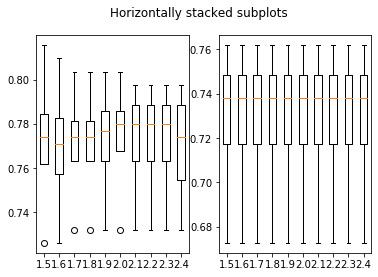

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.boxplot(p_results['l2'])
ax1.set_xticklabels(p_names['l2'])
ax2.boxplot(p_results['none'])
ax2.set_xticklabels(p_names['none'])
plt.show()

In [10]:
list_i = np.linspace(.1, 10., 100)

c_models = {i: LogisticRegression(max_iter=MAX_ITER, random_state=seed, tol=TOL, C=i, warm_start=True)
            for i in np.linspace(.1, 10, 100)}

results = []
names = []

for name in c_models:
    since = time.time()
    model = c_models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training 0.1 : accuracy: 0.652, std: 0.007
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.2 : accuracy: 0.717, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.30000000000000004 : accuracy: 0.729, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.4 : accuracy: 0.734, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.5 : accuracy: 0.747, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.6 : accuracy: 0.756, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.7000000000000001 : accuracy: 0.759, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.8 : accuracy: 0.765, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.9 : accuracy: 0.772, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 1.0 : accuracy: 0.775, std: 0.031
[TIME_CONSUMPTION

[CROSS_VAL_SCORE] Training 8.1 : accuracy: 0.775, std: 0.039
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.2 : accuracy: 0.777, std: 0.039
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.3 : accuracy: 0.778, std: 0.039
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.4 : accuracy: 0.778, std: 0.039
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.5 : accuracy: 0.775, std: 0.037
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.6 : accuracy: 0.775, std: 0.037
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.7 : accuracy: 0.777, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.8 : accuracy: 0.775, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.9 : accuracy: 0.775, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 9.0 : accuracy: 0.777, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL

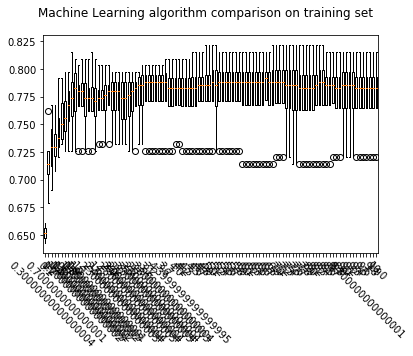

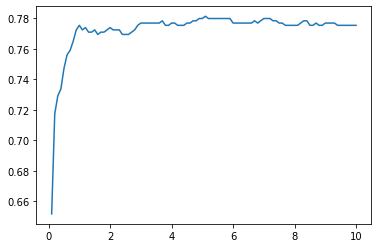

In [11]:
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=-45)
plt.show()

accuracies = [r.mean() for r in results]
plt.plot(list_i, accuracies)
plt.show()

### KNN hyperparam tunning

K 

In [12]:
list_i = range(1, 30)

k_models = {k: KNeighborsClassifier(n_neighbors=k) for k in list_i}

results = []
names = []

for name in k_models:
    since = time.time()
    model = k_models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    

[CROSS_VAL_SCORE] Training 1 : accuracy: 0.705, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 2 : accuracy: 0.656, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 3 : accuracy: 0.664, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 4 : accuracy: 0.683, std: 0.040
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 5 : accuracy: 0.693, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 6 : accuracy: 0.686, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 7 : accuracy: 0.685, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 8 : accuracy: 0.688, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 9 : accuracy: 0.686, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 10 : accuracy: 0.661, std: 0.019
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 11

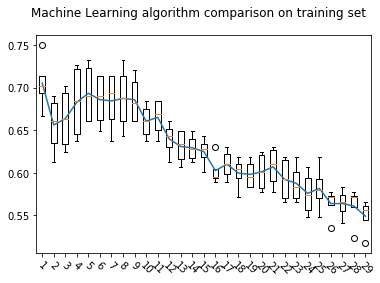

In [13]:
# def plot_hypertune(params, model_names, scores):
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=-45)
# plt.show()

accuracies = [r.mean() for r in results]
plt.plot(list_i, accuracies)
plt.show()

### Random Forest

1. Error function
2. n_estimators

In [14]:
rf_gini_acc = []
rf_gini_time_list = []
rf_entropy_acc = []
rf_entropy_time_list = []
rf_loss_f_n_list = np.hstack([np.array([10,50,100,500]),np.linspace(600,1500,num=5)])
for n in rf_loss_f_n_list:
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='gini')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training gini, n_estimators: {}, accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    rf_gini_time_list.append(time_elapsed)
    rf_gini_acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='entropy')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training entropy, n_estimators: {}, accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    rf_entropy_time_list.append(time_elapsed)
    rf_entropy_acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training gini, n_estimators: 10.0, accuracy: 0.749, std: 0.043
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 10.0, accuracy: 0.737, std: 0.045
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training gini, n_estimators: 50.0, accuracy: 0.824, std: 0.047
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 50.0, accuracy: 0.805, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training gini, n_estimators: 100.0, accuracy: 0.833, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 100.0, accuracy: 0.820, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training gini, n_estimators: 500.0, accuracy: 0.839, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 500.0, accuracy: 0.829, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 9s
[CROSS_VAL_SCORE] Training gini,

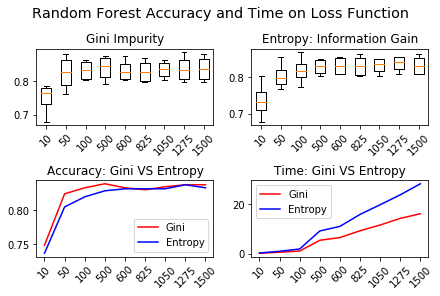

In [16]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(6, 2)
fig.suptitle('Random Forest Accuracy and Time on Loss Function', fontsize='x-large')

ax1 = fig.add_subplot(gs[0:3,0])
plt.boxplot(rf_gini_acc)
ax1.set_xticklabels([int(x) for x in rf_loss_f_n_list])
plt.title('Gini Impurity')
plt.xticks(rotation=45, horizontalalignment="center")

ax2 = fig.add_subplot(gs[0:3,1 ])
plt.boxplot(rf_entropy_acc)
ax2.set_xticklabels([int(x) for x in rf_loss_f_n_list])
plt.title('Entropy: Information Gain')
plt.xticks(rotation=45, horizontalalignment="center")

ax3 = fig.add_subplot(gs[3:6,0])
plt.title('Accuracy: Gini VS Entropy')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], [x.mean() for x in rf_gini_acc], c='r', label='Gini')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], [x.mean() for x in rf_entropy_acc], c='b', label='Entropy')
plt.legend()
plt.xticks(rotation=45, horizontalalignment="center")

ax3 = fig.add_subplot(gs[3:6,1])
plt.title('Time: Gini VS Entropy')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], rf_gini_time_list, c='r', label='Gini')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], rf_entropy_time_list, c='b', label='Entropy')
plt.legend()
plt.xticks(rotation=45, horizontalalignment="center")
plt.show()

In [17]:
acc = []
time_list = []
n_list_2 = np.hstack([np.array([10,50,100,500]),np.linspace(600,1400,num=5),np.array([3000,5000])])
for n in n_list_2:
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='gini')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training n_estimators: {} : accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    time_list.append(time_elapsed)
    acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


[CROSS_VAL_SCORE] Training n_estimators: 10.0 : accuracy: 0.740, std: 0.037
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training n_estimators: 50.0 : accuracy: 0.838, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training n_estimators: 100.0 : accuracy: 0.830, std: 0.040
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training n_estimators: 500.0 : accuracy: 0.835, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 4s
[CROSS_VAL_SCORE] Training n_estimators: 600.0 : accuracy: 0.830, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training n_estimators: 800.0 : accuracy: 0.833, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 7s
[CROSS_VAL_SCORE] Training n_estimators: 1000.0 : accuracy: 0.836, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 9s
[CROSS_VAL_SCORE] Training n_estimators: 1200.0 : accuracy: 0.838, std: 0.024
[TIME_CONSUMPTION] Finishing in 0m 11s
[CROSS_VAL_SCORE] Training n_estimators: 1400.0 : accuracy: 0.839, std: 0.023
[

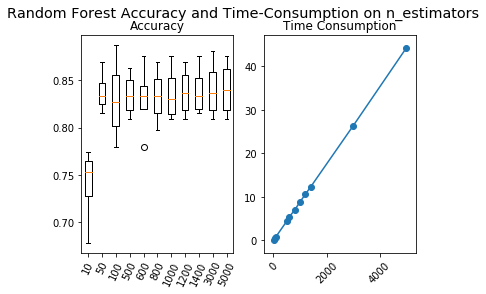

In [19]:
fig = plt.figure()
fig.suptitle("Random Forest Accuracy and Time-Consumption on n_estimators", fontsize='x-large')
ax = fig.add_subplot(121)
plt.boxplot(acc)
ax.set_xticklabels([int(x) for x in n_list_2])
plt.xticks(rotation=65, horizontalalignment="center")
plt.title('Accuracy')
ax = fig.add_subplot(1,2,2)
ax.plot([int(x) for x in n_list_2], time_list)
ax.scatter([int(x) for x in n_list_2], time_list)
plt.xticks(rotation=45, horizontalalignment="center")
plt.title('Time Consumption')
plt.show()

### SVM
1. Loss Function
2. C
3. poly degree

In [21]:
svm_ker_acc = {'linear': [],
      'poly': [],
      'rbf': [],
      'sigmoid': []}
svm_ker_time_list = {'linear': [],
      'poly': [],
      'rbf': [],
      'sigmoid': []}
svm_ker_n_list = np.hstack([np.linspace(1,5,5),8,10,20,50,100])
for c in svm_ker_n_list:
    for ker in ["linear", "poly", 'rbf', 'sigmoid']:
        since = time.time()
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        model = SVC(random_state=seed, kernel=ker, C=c, decision_function_shape='ovo')
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        print("[CROSS_VAL_SCORE] Training kernal: {}, C = {}, accuracy: {:.3f}, std: {:.3f}".format(ker,c, cv_results.mean(), cv_results.std()))
        time_elapsed = time.time() - since
        svm_ker_time_list[ker].append(time_elapsed)
        svm_ker_acc[ker].append(cv_results)
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training kernal: linear, C = 1.0, accuracy: 0.775, std: 0.036
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 1.0, accuracy: 0.756, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: rbf, C = 1.0, accuracy: 0.738, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: sigmoid, C = 1.0, accuracy: 0.661, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: linear, C = 2.0, accuracy: 0.787, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 2.0, accuracy: 0.781, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: rbf, C = 2.0, accuracy: 0.774, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: sigmoid, C = 2.0, accuracy: 0.702, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: linear, C = 3.0, accuracy: 0.

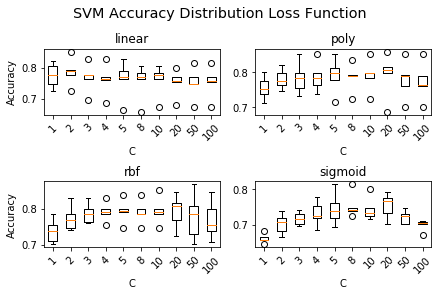

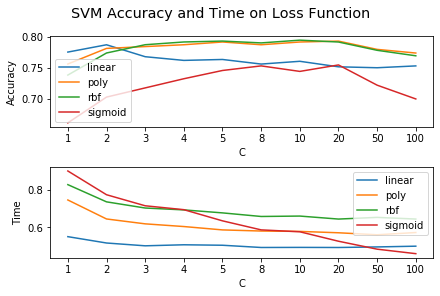

In [22]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
fig.suptitle('SVM Accuracy Distribution Loss Function', fontsize='x-large')

for i, key in enumerate(svm_ker_acc.keys()):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    plt.boxplot(svm_ker_acc[key])
    ax.set_xticklabels([int(x) for x in svm_ker_n_list])
    if i%2 == 0:
        plt.ylabel('Accuracy')
    plt.xlabel('C')
    plt.title(key)
    plt.xticks(rotation=45, horizontalalignment="center")

plt.show()



fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=2)
fig.suptitle('SVM Accuracy and Time on Loss Function', fontsize='x-large')

ax1 = fig.add_subplot(gs[0,:])
for i, key in enumerate(svm_ker_acc.keys()):
    ax1.plot([str(int(x)) for x in svm_ker_n_list], [x.mean() for x in svm_ker_acc[key]], label=key)
plt.ylabel('Accuracy')
plt.xlabel('C')
ax1.legend()

ax2 = fig.add_subplot(gs[1,:])
for i, key in enumerate(svm_ker_acc.keys()):
    ax2.plot([str(int(x)) for x in svm_ker_n_list], svm_ker_time_list[key], label=key)
plt.ylabel('Time')
plt.xlabel('C')
ax2.legend()
plt.show()

## Use poly

In [23]:
# C of poly
# degree for poly
svm_c_list = np.linspace(1,30,30)
svm_degree_list = range(1,21)
svm_shape = (len(svm_c_list), len(svm_degree_list))
svm_acc = pd.DataFrame(np.zeros(svm_shape))
svm_acc.columns = svm_degree_list
svm_acc.index = svm_c_list
svm_time = pd.DataFrame(np.zeros(svm_shape))
svm_time.columns = svm_degree_list
svm_time.index = svm_c_list

for degree in svm_degree_list:
    for c in svm_c_list:
        since = time.time()
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        model = SVC(random_state=seed, kernel='poly', C=c, degree=degree, decision_function_shape='ovo')
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        print("[CROSS_VAL_SCORE] Training kernal: poly,degree = {}, C = {}, accuracy: {:.3f}, std: {:.3f}".format(degree, c, cv_results.mean(), cv_results.std()))
        time_elapsed = time.time() - since
        svm_acc.loc[c, degree] = cv_results.mean()
        svm_time.loc[c, degree] = time_elapsed
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 1.0, accuracy: 0.708, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 2.0, accuracy: 0.741, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 3.0, accuracy: 0.763, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 4.0, accuracy: 0.765, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 5.0, accuracy: 0.768, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 6.0, accuracy: 0.775, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 7.0, accuracy: 0.774, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 8.0, accuracy: 0.775, std: 0.038
[TIME_CONSUMPTION] Fin

[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 6.0, accuracy: 0.798, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 7.0, accuracy: 0.793, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 8.0, accuracy: 0.787, std: 0.036
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 9.0, accuracy: 0.787, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 10.0, accuracy: 0.792, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 11.0, accuracy: 0.784, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 12.0, accuracy: 0.786, std: 0.046
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 13.0, accuracy: 0.787, std: 0.044
[TIME_CONSUMPTION]

[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 11.0, accuracy: 0.792, std: 0.036
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 12.0, accuracy: 0.789, std: 0.038
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 13.0, accuracy: 0.789, std: 0.038
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 14.0, accuracy: 0.790, std: 0.038
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 15.0, accuracy: 0.787, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 16.0, accuracy: 0.790, std: 0.043
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 17.0, accuracy: 0.790, std: 0.043
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 18.0, accuracy: 0.793, std: 0.044
[TIME_CONSUMPT

[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 16.0, accuracy: 0.786, std: 0.044
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 17.0, accuracy: 0.786, std: 0.044
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 18.0, accuracy: 0.787, std: 0.043
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 19.0, accuracy: 0.787, std: 0.043
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 20.0, accuracy: 0.784, std: 0.046
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 21.0, accuracy: 0.784, std: 0.046
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 22.0, accuracy: 0.786, std: 0.045
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 23.0, accuracy: 0.786, std: 0.045
[TIME_CONSUMPT

[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 21.0, accuracy: 0.766, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 22.0, accuracy: 0.763, std: 0.043
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 23.0, accuracy: 0.763, std: 0.043
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 24.0, accuracy: 0.763, std: 0.043
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 25.0, accuracy: 0.766, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 26.0, accuracy: 0.765, std: 0.042
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 27.0, accuracy: 0.765, std: 0.042
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 28.0, accuracy: 0.763, std: 0.041
[TIME_CONSUMPT

[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 25.0, accuracy: 0.754, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 26.0, accuracy: 0.754, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 27.0, accuracy: 0.753, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 28.0, accuracy: 0.753, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 29.0, accuracy: 0.751, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 30.0, accuracy: 0.751, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 12, C = 1.0, accuracy: 0.600, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 12, C = 2.0, accuracy: 0.695, std: 0.029
[TIME_CO

[CROSS_VAL_SCORE] Training kernal: poly,degree = 13, C = 29.0, accuracy: 0.729, std: 0.039
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 13, C = 30.0, accuracy: 0.728, std: 0.038
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 1.0, accuracy: 0.533, std: 0.013
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 2.0, accuracy: 0.623, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 3.0, accuracy: 0.674, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 4.0, accuracy: 0.693, std: 0.043
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 5.0, accuracy: 0.696, std: 0.042
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 6.0, accuracy: 0.698, std: 0.039
[TIME_CONSUM

[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 3.0, accuracy: 0.607, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 4.0, accuracy: 0.643, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 5.0, accuracy: 0.674, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 6.0, accuracy: 0.680, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 7.0, accuracy: 0.678, std: 0.036
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 8.0, accuracy: 0.681, std: 0.039
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 9.0, accuracy: 0.687, std: 0.042
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 10.0, accuracy: 0.689, std: 0.037
[TIME_CONSUMP

[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 7.0, accuracy: 0.641, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 8.0, accuracy: 0.664, std: 0.024
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 9.0, accuracy: 0.670, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 10.0, accuracy: 0.673, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 11.0, accuracy: 0.665, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 12.0, accuracy: 0.667, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 13.0, accuracy: 0.677, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 14.0, accuracy: 0.673, std: 0.038
[TIME_CON

[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 11.0, accuracy: 0.623, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 12.0, accuracy: 0.634, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 13.0, accuracy: 0.638, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 14.0, accuracy: 0.650, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 15.0, accuracy: 0.650, std: 0.024
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 16.0, accuracy: 0.652, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 17.0, accuracy: 0.650, std: 0.016
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 18.0, accuracy: 0.650, std: 0.022
[TIME_

In [24]:
x_acc = []
y_acc = []
z_acc = []
for degree in svm_degree_list:
    for c in svm_c_list:
        x_acc.append(degree)
        y_acc.append(c)
        z_acc.append(svm_acc.loc[c, degree])
# z_acc_sigmoid = 1 / (1 + np.exp(-1 * np.array(z_acc)))
x_time = []
y_time = []
z_time = []
for degree in svm_degree_list:
    for c in svm_c_list:
        x_time.append(degree)
        y_time.append(c)
        z_time.append(svm_time.loc[c, degree])
# z_time_sigmoid = 1 / (1 + np.exp(-1 * np.array(z_time)))

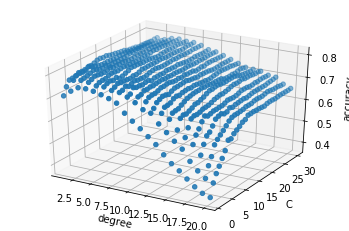

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_acc, y_acc, z_acc, marker='o')
ax.set_xlabel('degree')
ax.set_ylabel('C')
ax.set_zlabel('accuracy')
plt.show()

In [26]:
df_acc = pd.DataFrame({
    'degree': x_acc,
    'C': y_acc,
    'accuracy': z_acc
})
fig = px.scatter_3d(df_acc, x='degree', y='C', z='accuracy', color='accuracy', size='accuracy', size_max=13)
fig.show()

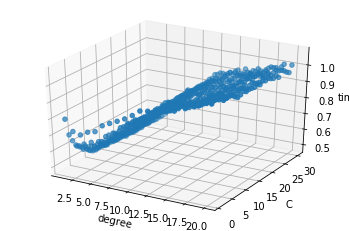

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_time, y_time, z_time, marker='o')
ax.set_xlabel('degree')
ax.set_ylabel('C')
ax.set_zlabel('time')
plt.show()

In [28]:
df_time = pd.DataFrame({
    'degree': x_time,
    'C': y_time,
    'time': z_time
})
fig = px.scatter_3d(df_time, x='degree', y='C', z='time', color='time', size_max=13)
fig.show()

In [29]:
i = np.array(z_acc).argmax()
svm_c = y_acc[i]
svm_degree = x_acc[i]

print("C = {}, degree = {}".format(c, degree))

C = 30.0, degree = 20


[CROSS_VAL_SCORE] Training LR : accuracy: 0.771, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training LDA : accuracy: 0.359, std: 0.061
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training KNN : accuracy: 0.686, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training CART : accuracy: 0.635, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training RF : accuracy: 0.841, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 10s
[CROSS_VAL_SCORE] Training NB : accuracy: 0.464, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training SVM : accuracy: 0.787, std: 0.039
[TIME_CONSUMPTION] Finishing in 0m 0s


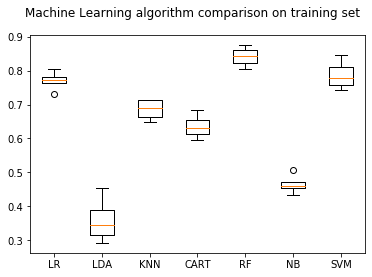

In [30]:
num_trees = 1150
models = {'LR': LogisticRegression(max_iter=1000, random_state=seed, tol=0.0001, C=1.8, warm_start=True),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(n_neighbors = 6),
          'CART': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed, criterion='gini', warm_start=True),
          'NB': GaussianNB(),
          'SVM': SVC(random_state=seed, kernel='poly', C=svm_c, degree=svm_degree)}

results = []
names = []

for name in models.keys():
    since = time.time()
    model = models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Train the models and see the accuracy rate on both training and testing set

In [31]:
for key in models.keys():
    since = time.time()
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[RESULT] LR accuracy on training set: 0.915
[RESULT] LR accuracy on testing set: 0.815
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] LDA accuracy on training set: 0.984
[RESULT] LDA accuracy on testing set: 0.529
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] KNN accuracy on training set: 0.784
[RESULT] KNN accuracy on testing set: 0.739
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] CART accuracy on training set: 1.000
[RESULT] CART accuracy on testing set: 0.697
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] RF accuracy on training set: 1.000
[RESULT] RF accuracy on testing set: 0.866
[TIME_CONSUMPTION] Finishing in 0m 3s
[RESULT] NB accuracy on training set: 0.649
[RESULT] NB accuracy on testing set: 0.462
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] SVM accuracy on training set: 0.946
[RESULT] SVM accuracy on testing set: 0.824
[TIME_CONSUMPTION] Finishing in 0m 0s


### Best model: Random Froest
We build some examples using random forest model.

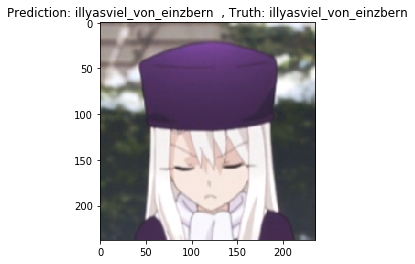

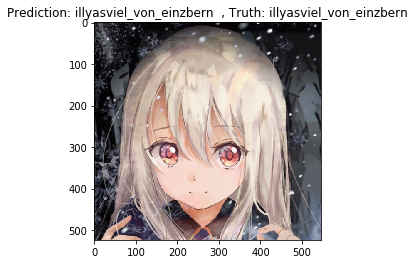

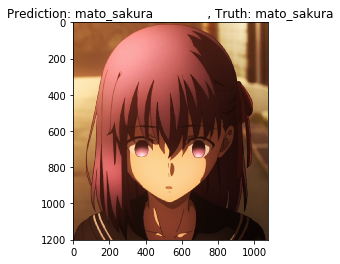

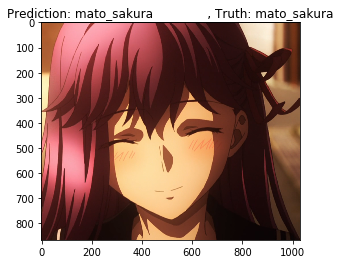

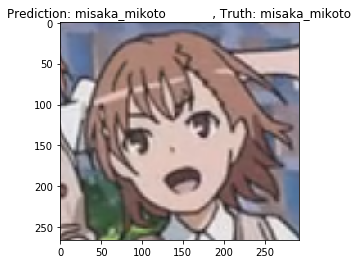

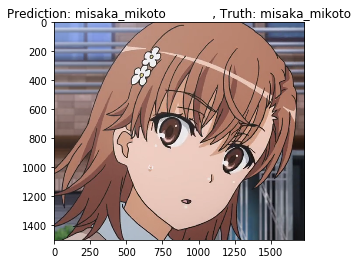

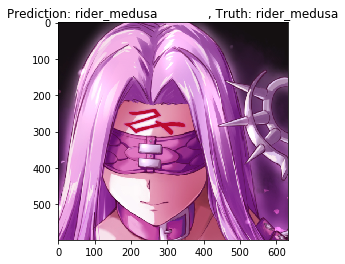

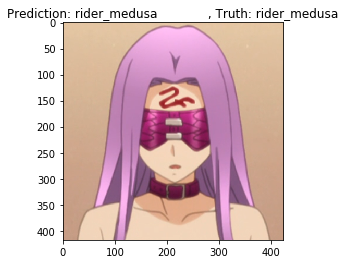

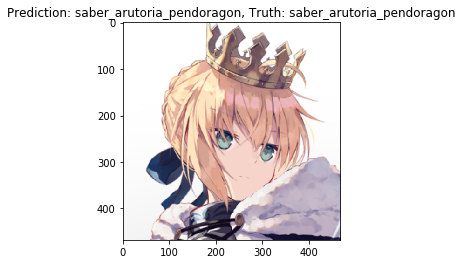

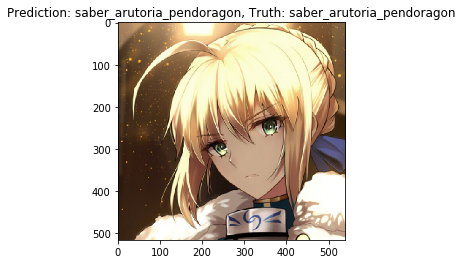

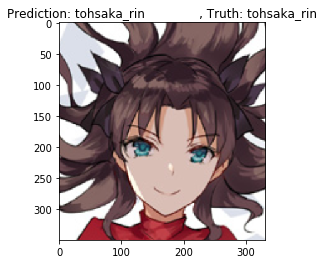

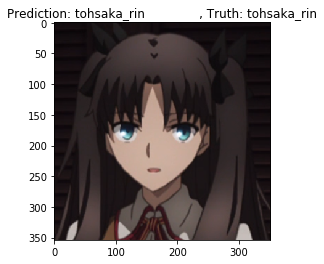

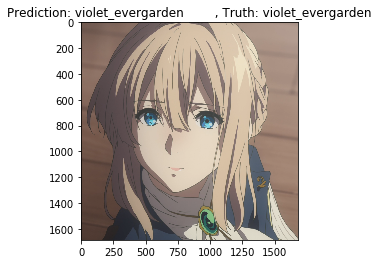

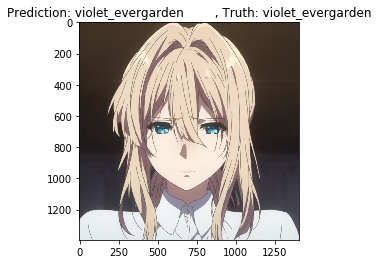

In [32]:
best_model = models['RF']

modeling_data_path = os.path.join('data_set', 'modeling_data')
characters_folders = os.listdir(modeling_data_path)
for character in characters_folders:
    pic_folder = os.path.join(modeling_data_path, character)
    all_pics = os.listdir(pic_folder)
    sampling = random.choices(all_pics, k=2)
    for pic in sampling:
        pic_dir = os.path.join(pic_folder, pic)
        image = cv2.imread(pic_dir)
        display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pic_feature = loader.extract_single_image(pic_dir)
        pic_feature = normalizer.transform(np.array([pic_feature]))
        # print(pic_feature.shape)
        pred_result = best_model.predict(pic_feature)[0]
        pred_result = name_label_map[pred_result]
        # print(pred_result)
        plt.imshow(display_image)
        plt.title("Prediction: {}, Truth: {}".format(pred_result, character))
        plt.show()

### Confusion Matrix

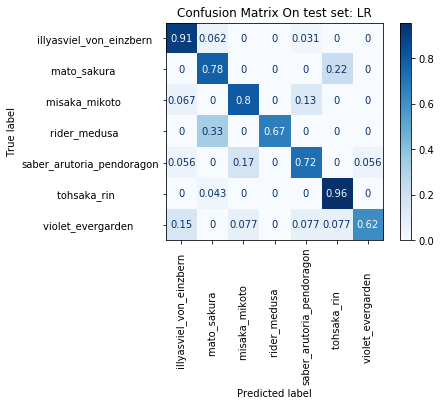

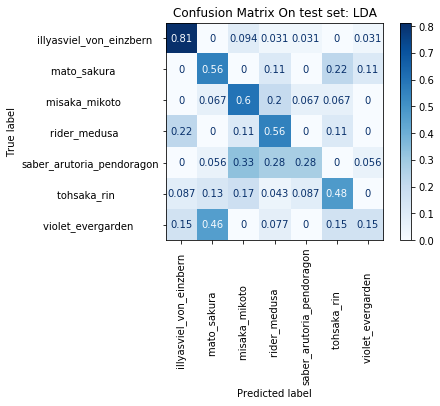

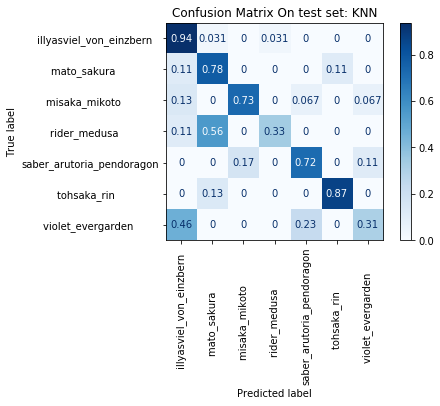

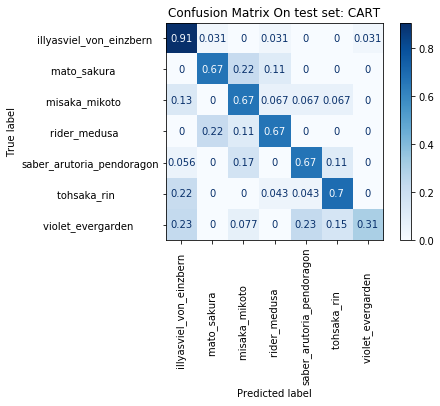

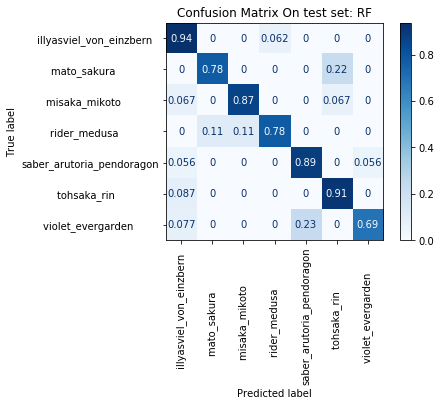

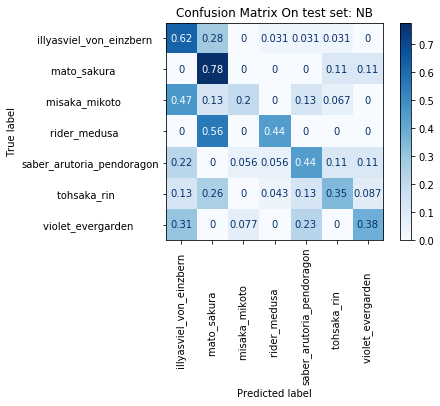

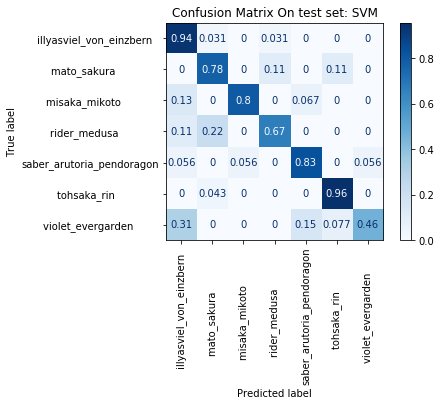

In [33]:
for key in models.keys():
    model = models[key]
    disp = plot_confusion_matrix(model, fv_tst, fv_l_tst,
                                 display_labels=name_label_map,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.xticks(rotation='vertical', horizontalalignment="center")
    disp.ax_.set_title("Confusion Matrix On test set: {}".format(key))
    plt.show()